# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [2]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[02/16/25 18:10:24] INFO     Found credentials from IAM Role:                                   ]8;id=466650;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=891407;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Visualize Data

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

# Create list of maps
maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'Maine_Coon_82.jpg'

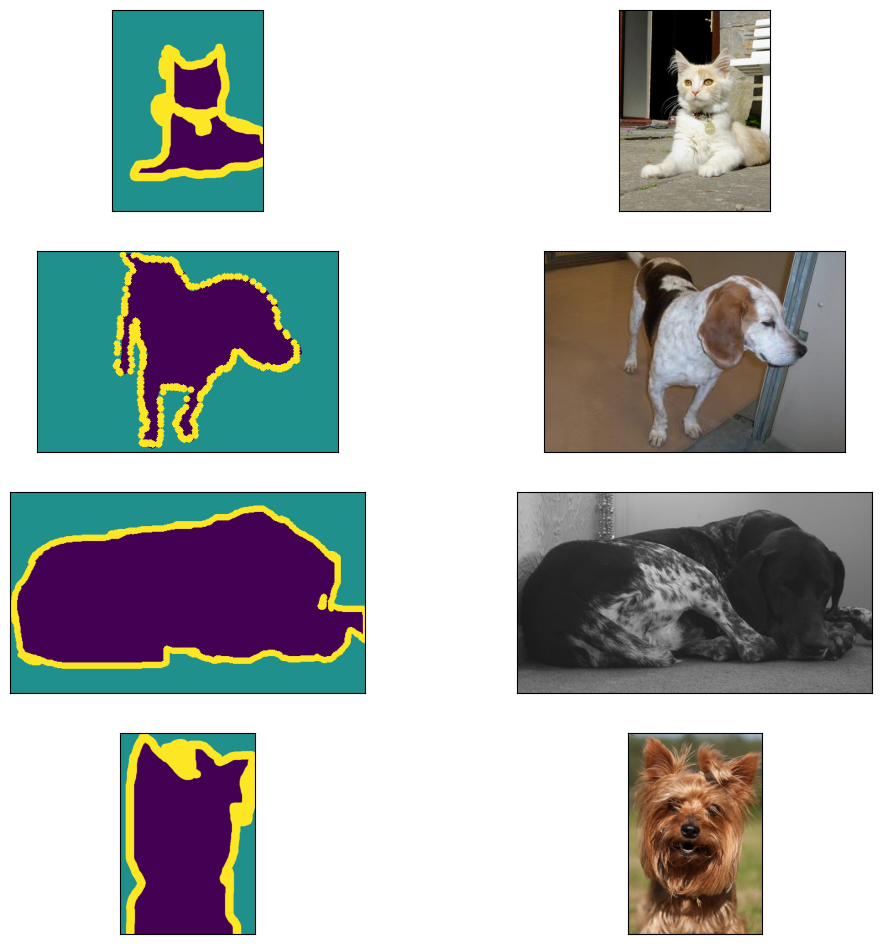

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    # Randomly select image and find corresponding map
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [7]:
# Unique pixel values --> referring to the 3 pixel classes (background, foreground, border)
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [8]:
role = sagemaker.get_execution_role()
bucket_name = 'coursera-dogs-bucket'
training_image = get_image_uri(boto3.Session().region_name,'semantic-segmentation',
                               repo_version='latest')
print(training_image)

[02/16/25 18:10:34] INFO     Found credentials from IAM Role:                                   ]8;id=843679;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=169900;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[02/16/25 18:10:35] WARNING  The method get_image_uri has been renamed in sagemaker>=2.          ]8;id=817508;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=668209;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=875596;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=378236;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#391\391]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=831364;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=822751;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [9]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [10]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:19<00:00, 372.44it/s]


In [11]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [12]:
print(len(train_annots), len(train_images))

5539 5539


# Uploading Data to S3 bucket

In [13]:
sess = sagemaker.Session()
print('Starting upload')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name, 
                                            key_prefix='train_annotation')
print('Training annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, 
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name, 
                                                 key_prefix='validation_annotation')
print('Validation annotations uploaded')

[02/16/25 18:10:55] INFO     Found credentials from IAM Role:                                   ]8;id=704392;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=316337;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Starting upload
Training images uploaded
Training annotations uploaded
Validation images uploaded
Validation annotations uploaded


In [14]:
s3_validation_annotation_path

's3://coursera-dogs-bucket/validation_annotation'

# SageMaker Estimator

In [15]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.2xlarge',
    # train_instance_type='ml.p3.16xlarge',
    train_volume_size=100,
    train_max_run=36000,
    input_mode='File',
    output_path='s3://coursera-dogs-bucket/output',
    sagemaker_session=sess
)

[02/16/25 18:22:31] WARNING  train_instance_count has been renamed in sagemaker>=2.              ]8;id=909339;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=144848;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_instance_type has been renamed in sagemaker>=2.               ]8;id=880165;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=409298;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_max_run has been renamed in sagemaker>=2.                     ]8;id=918488;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=921653;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_volume_size has been renamed in sagemaker>=2.                 ]8;id=416889;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=823198;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Found credentials from IAM Role:                                   ]8;id=878546;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=579317;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

# Hyperparameters

In [16]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    epochs=10,
    learning_rate=0.0001,
    optimizer='rmsprop',
    lr_scheduler='poly',
    mini_batch_size=16,
    num_training_samples=len(train_images)
)

# Data Channels
Specify where specific folders are in S3

In [17]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated',
                                content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                                content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path, distribution='FullyReplicated',
                                content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path, distribution='FullyReplicated',
                                content_type='image/png', s3_data_type='S3Prefix')


                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=870883;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=648554;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=788949;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=859877;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=348859;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=304470;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=257466;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=151712;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [20]:
data_channel = {
    'train': train_data,
    'validation': validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation': validation_annotation_data
}
data_channel

{'train': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f05602937f0>,
 'validation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f05602936d0>,
 'train_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f05582c4d90>,
 'validation_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f0560292e90>}

# Model Training

In [ ]:
model.fit(inputs=data_channel, logs=True)

[02/16/25 18:40:00] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=192654;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=546160;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=145030;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=449006;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             semantic-segmentation-2025-02-16-18-40-00-992                                         

2025-02-16 18:40:02 Starting - Starting the training job...
..25-02-16 18:40:26 Starting - Preparing the instances for training.
....................Downloading - Downloading input data.
........16 18:44:29 Downloading - Downloading the training image.
.Docker entrypoint called with argument(s): trainpleted. Training in progress..
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Feb 16 18:46:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                   

# Deploy Model

In [22]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

[02/16/25 19:43:59] INFO     Creating model with name:                                              ]8;id=370281;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=686697;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\
                             semantic-segmentation-2025-02-16-19-43-58-875                                         

                    INFO     Creating endpoint-config with name                                     ]8;id=177793;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=704756;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\
                             semantic-segmentation-2025-02-16-19-43-58-875                                         

                    INFO     Creating endpoint with name                                            ]8;id=701056;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=259486;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\
                             semantic-segmentation-2025-02-16-19-43-58-875                                         

--------------!
Model deployed!


In [23]:
deployed_model

# Predictions

In [24]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1851


In [25]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [26]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [27]:
mask = np.array(Image.open(io.BytesIO(results)))

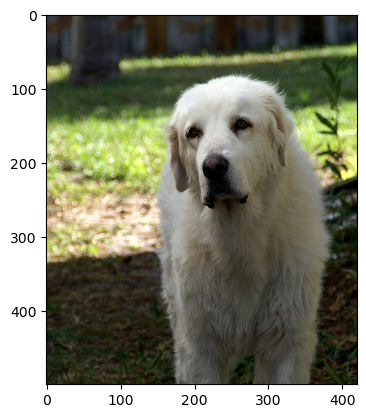

In [28]:
plt.imshow(plt.imread(image_path));

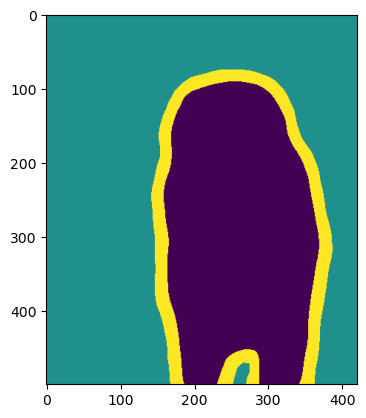

In [29]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [30]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

[02/16/25 19:51:37] WARNING  The endpoint attribute has been renamed in sagemaker>=2.            ]8;id=846921;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=439004;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Deleting endpoint with name:                                           ]8;id=213935;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=63842;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\
                             semantic-segmentation-2025-02-16-19-43-58-875                                         